# AE-LEGO
This notebook defines a set of building blocks to play with and indicator-metrics.

* [Dataset](#data)
* [Models](#model)
    * [Semantic context](#semantic) (conditional VAE)
    * [Auto-Encoder](#ae)
    * [Vanilla VAE](#vae)
    * [Discrete VAE](#dvae)
    * [Fancy beasts](#beasts)
        * [TwinVAE](#twin)
        * [HydraVAE](#hydra)
* [Loss Definition](#loss)
    * [Reconstruction](#rec)
    * [KL-diversion](#kld)
        * [VAE](#kld)
        * [DVAE](#kld-dvae)
    * [Helper terms](#helpers)
        * [Contrast metric](#contrast)
        * [Semantic align](#align)
        * [Temperature](#tau)
        

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import colormaps, ticker
from IPython.display import SVG
from typing import Optional

from torch import nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.distributions import OneHotCategorical, RelaxedOneHotCategorical
from torchsummary import summary

from torchvision.datasets import MNIST

In [2]:
from scripts.backbone import *
from scripts.aelego import *
from scripts.utils import *

In [3]:
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


<a name="data"></a>

## Dataset
This toy example uses MNIST. We only add `transforms` to match the target resolution and to make different categoric labels for some experiments.

In [4]:
trainset = MNIST(root='./data', train=True, download=True)
testset  = MNIST(root='./data', train=False, download=True)

print(len(trainset), len(testset))
trainset[0]

60000 10000


(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
IMG_SIZE = 28
REC_SIZE = 22

class AEDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X, Y = self.data[idx]
        inputs = torch.Tensor(np.array(X)/255.).unsqueeze(0)
        targets = torch.Tensor(np.array(X.resize((REC_SIZE, REC_SIZE))))
        labels = Y
        return inputs, targets, labels

    
X, Y, C = AEDataset(trainset)[0]
X.shape, Y.shape, C

(torch.Size([1, 28, 28]), torch.Size([22, 22]), 5)

For the semantic experiments we want some different labels, let's make up some example:

In [6]:
SEMANTIC_DIM = 4
SEMANTIC_LABELS = ['1,4,7','0,8','2,3,5','6,9'] ### artificial, but no completely senseless


class ContextDataset(AEDataset):
    def __getitem__(self, idx):
        X, Y, C = super().__getitem__(idx)
        labels = {1:0, 4:0, 7:0, 0:1, 8:1, 2:2, 3:2, 5:2, 6:3, 9:3}
        return X, Y, labels[C]

    
dataset = ContextDataset

In [7]:
for demo_batch in DataLoader(dataset(trainset), batch_size=16, shuffle=True):
    X, Y, C = demo_batch
    break
X.shape, Y.shape, C

(torch.Size([16, 1, 28, 28]),
 torch.Size([16, 22, 22]),
 tensor([1, 3, 2, 0, 3, 2, 2, 2, 2, 0, 3, 3, 3, 2, 0, 3]))

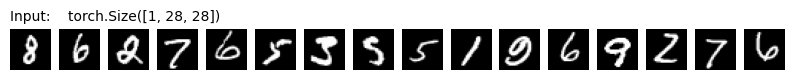

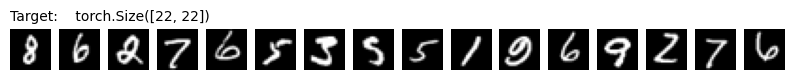

In [8]:
show_inputs(demo_batch)
show_targets(demo_batch)
# test inputs
X = X.to(DEVICE); C = C.to(DEVICE)

<a name="model"></a>

## Models
For this experiments we assume that we have some visual feature extractor (backbone) and some visual decoder (like high resolution segmentation). We want to explore potential extensions with generative capabilities and maybe integration with some arbitrary semantic context. Our goal is to construct the middle part (bottleneck) which connects both and can be trained as a stand-alone model or as a part of the original one.

A simple example we are going to use in this notebook comes from a shallow segmentation `unet` with standard `ResNet18` blocks and self-attention (quite an overhead for MNIST which could be handled with a couple of dense layers, we just want something more interesting here). The original system could be anything, flat-linear, CNN or ViT, the goal is to explore how the extension layers and hybrid insertions will interact, and what could be frozen after all without loosing performance.

#### Encoder
The encoder is a neural network that outputs a representation of data.

In the example we've got (a shallow unet-model) the encoder outputs a list: feature-maps from all the resolution levels (skip-connections). We only interested in the last, bottom-level output which is the most "abstract" feature-map. Another issue with skip-connections is that information might bypass the bottleneck resulting the bottom level not being a best representation. In our case it also lacks compression.

In [9]:
encoder = get_encoder(pretrained=False, frozen=False)
summary(encoder, (1, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]               6
            Conv2d-2           [-1, 64, 28, 28]             128
         GroupNorm-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
     SelfAttention-5           [-1, 64, 28, 28]               0
            Conv2d-6           [-1, 64, 28, 28]             640
         GroupNorm-7           [-1, 64, 28, 28]             128
              GELU-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          36,928
        GroupNorm-10           [-1, 64, 28, 28]             128
           Conv2d-11           [-1, 64, 28, 28]             128
        ConvBlock-12           [-1, 64, 28, 28]               0
        MaxPool2d-13           [-1, 64, 14, 14]               0
  DownsampleBlock-14  [[-1, 64, 14, 14]

In [10]:
# let's see the output produced for the MNIST data input
for output in encoder(X):
    print(output.shape)

torch.Size([16, 64, 28, 28])
torch.Size([16, 128, 14, 14])
torch.Size([16, 256, 7, 7])
torch.Size([16, 512, 3, 3])


#### Decoder
The decoder takes representation and reconstructs the input.

In the example we've got `unet-decoder` takes the list of feature-maps and outputs the set of segmentation masks (class-channels). We need all the information at the bottleneck: our `unet` example model has training option `bridge=False` (no skip-connections) that's the setting we will use for our extension training.

In [11]:
decoder = get_decoder()
summary(decoder, [(512, 3, 3)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 8, 8]       2,097,408
            Conv2d-2            [-1, 768, 8, 8]         197,376
            Conv2d-3            [-1, 256, 8, 8]          65,792
         GroupNorm-4            [-1, 256, 8, 8]             512
              ReLU-5            [-1, 256, 8, 8]               0
     SelfAttention-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         590,080
         GroupNorm-8            [-1, 256, 8, 8]             512
              GELU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         590,080
        GroupNorm-11            [-1, 256, 8, 8]             512
           Conv2d-12            [-1, 256, 8, 8]          65,792
        ConvBlock-13            [-1, 256, 8, 8]               0
  ConvTranspose2d-14          [-1, 128,

In [12]:
decoder(output).shape

torch.Size([16, 1, 38, 38])

<a name="semantic"></a>

### Semantic context

We want to explore the situations when some semantic vector could be present and injected to instruct the model. We consider any combination: same or different semantic capacity for the encoder and decoder. We consider the arbitrary floating point semantic vector. It could be a `relaxed` one-hot representation of some label or anything at all. We can use the labels from the data. Above we made some up:

In [13]:
SEMANTIC_DIM

4

This is somewhat different from a vanilla conditional VAE which is supervised deterministic model and assumes a fixed set of the categories we are committed to. Our setup assumes a presence of a noisy signal which might interact and even conflict with our "current perception".

<a name="ae"></a>

### Auto-Encoder
We've got encoder and decoder, we need a layer (bottleneck) to produce compressed representation (our backbone returns `-1, 512, 3, 3` at its bottom level) and a layer to inject some optional semantic context (condition).

In [14]:
# to avoid distraction and to point that it belongs to an `adapter` layer
LOCAL = 512

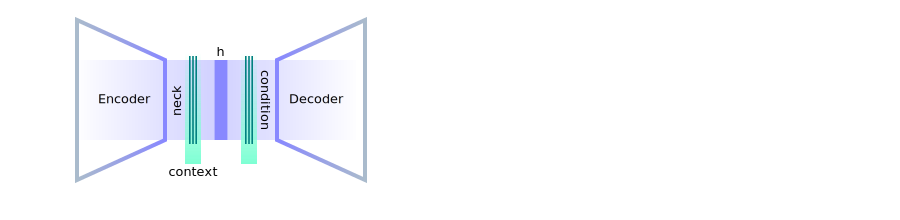

In [15]:
SVG('assets/ae.svg')

In [16]:
class Neck(nn.Module):
    """
    Takes our original encoder input and optional semantic context vector
    and converts them to a vector of a target latent space size
    
    We intentianally create a separate projection for the context injection:
    direct access to that leyer cold be useful for some other modules in the system or diagnostics
    """
    def __init__(self, hidden_dim: int, semantic_dim: int = 0):
        super().__init__()
        self.semantic_dim = semantic_dim
        # adapt our specific encoder output
        self.adapter = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(start_dim = 1))
        # inject context if present
        self.context_projection = nn.Sequential(nn.Linear(semantic_dim + LOCAL, LOCAL), nn.ReLU())
        # compress to target latent space dim
        self.latent_projection = nn.Linear(LOCAL, hidden_dim)
        
    def forward(self, x, context: Optional[Tensor] = None):
        h = self.adapter(x[-1])
        if self.semantic_dim > 0 and not context is None:
            h = self.context_projection(torch.cat((h, context), 1))
        return self.latent_projection(h)


# check with our encoder output
output = encoder(X)
# make a Neck with 256 target latent-dim and 4 semantic channel capacity
Neck(256, 4).to(DEVICE)(output, torch.rand(X.size(0), 4).to(DEVICE)).shape

torch.Size([16, 256])

Our first basic block is a vanilla auto-encoder. It does not have generative power and quite useless for any semantic context, however, it is easy to train and we keep it for diagnostics at least.

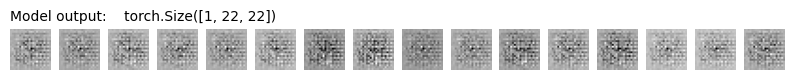

In [17]:
class AutoEncoder(nn.Module):
    """
    Takes our existing encoder and decoder and connects them
    via Neck module disabled semantic channel: all inputs except of visual are simply ignored
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.neck = Neck(LOCAL)
        
    def encode(self, x):
        return self.neck(self.encoder(x))
    
    def forward(self, x, **kwargs):
        h = self.encode(x)
        return self.decoder(h.view(*h.size(), 1, 1))
    

model = AutoEncoder(encoder, decoder).to(DEVICE)
show_model_output(model, demo_batch, tag='output')

<a name="vae"></a>

### Variational Auto-Encoder
VAE is a probabilistic generative model, it learns the data distribution (likelihood) which allows the trained model generate new data similar to the original: very useful if we need to build the system with `imagination` and `anomaly detection` capabilities. It could be trained in either `unsupervised` or any other setting.

The latent space $z$ is modeled as Gaussian mixture via [reparameterization trick](https://arxiv.org/abs/1809.10330).

Our next basic block is a VAE model with optional potentially noisy semantic channel.

In [18]:
# pick our target latent dim.
LATENT_DIM = 8

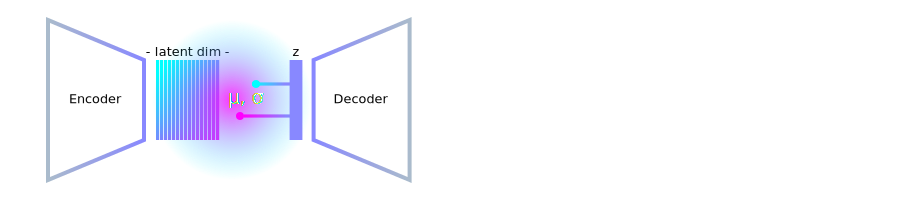

In [19]:
SVG('assets/vae.svg')

In [20]:
class ZEncoder(nn.Module):
    """
    Enhance our existing encoder with a sense of proper data distribution
    and allow some optional semantic channel interact with it
    """
    def __init__(self, encoder: nn.Module, latent_dim: int, semantic_dim: int = 0):
        super().__init__()
        self.latent_dim = latent_dim
        self.semantic_dim = semantic_dim
        self.encoder = encoder
        self.neck = Neck(LOCAL, semantic_dim)
        # reparametrization layers
        self.mean = nn.Linear(LOCAL, latent_dim)
        self.logvar = nn.Linear(LOCAL, latent_dim)
        
    def encode(self, x, context: Optional[Tensor] = None):
        return self.neck(self.encoder(x), context)

    def projection(self, x):
        return self.mean(x), self.logvar(x)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x, context: Optional[Tensor] = None):
        h = self.encode(x, context)
        mean, logvar = self.projection(h)
        z = self.reparameterize(mean, logvar)
        return z, mean, logvar
    

# try with our demo-input
Z = ZEncoder(encoder, LATENT_DIM).to(DEVICE)(X)[0]
Z.shape

torch.Size([16, 8])

<a name="condition"></a>

Our VAE encoder can handle `semantic channel`, so, we should construct the layer for `semantic injection` instructing a VAE decoder as well.

In [21]:
class Condition(nn.Module):
    """
    Takes latent representation input and optional semantic context vector
    and converts them to a decoder input
    
    Conceptually the same as Neck: a separate projection for the context injection to provide
    direct access to that leyer will be useful for state diagnostics during the training
    """
    def __init__(self, input_dim: int, output_dim: int, semantic_dim: int = 0):
        super().__init__()
        self.semantic_dim = semantic_dim
        # inject context if any
        self.context_projection = nn.Linear(semantic_dim + input_dim, input_dim)
        # adjust to the required output format
        self.output_projection = nn.Sequential(nn.Linear(input_dim, output_dim), nn.ReLU())
        
    def forward(self, z, context: Optional[Tensor] = None):
        if self.semantic_dim > 0 and not context is None:
            z = self.context_projection(torch.cat((z, context), 1))
        # return conditioned latent representation along with adjusted output for diagnostics
        return self.output_projection(z), z
    

<a name="zdecoder"></a>

In [22]:
class ZDecoder(nn.Module):
    """
    Enhance our existing decoder with ability to translate
    conditional latent representation into its native input
    """
    def __init__(self, decoder: nn.Module, latent_dim: int, semantic_dim: int = 0):
        super().__init__()
        self.latent_dim = latent_dim
        self.semantic_dim = semantic_dim
        self.decoder = decoder
        # make a conditional adapter to our encoder and decoder heads
        self.condition = Condition(latent_dim, LOCAL, semantic_dim)
    
    def forward(self, z, context: Optional[Tensor] = None):
        h, s = self.condition(z, context)
        h = h.view(h.size(0), LOCAL, 1, 1)
        return self.decoder(h), s


# try with our demo-input and no semantics
Z = ZEncoder(encoder, LATENT_DIM).to(DEVICE)(X)[0]
for output in ZDecoder(decoder, LATENT_DIM, SEMANTIC_DIM).to(DEVICE)(Z):
    print(output.shape)

torch.Size([16, 1, 22, 22])
torch.Size([16, 8])


In [23]:
# make up some dummy semantic vector
S = torch.rand(Z.size(0), SEMANTIC_DIM).to(DEVICE)
for output in ZDecoder(decoder, LATENT_DIM, SEMANTIC_DIM).to(DEVICE)(Z, S):
    print(output.shape)

torch.Size([16, 1, 22, 22])
torch.Size([16, 8])


In [24]:
class VAE(nn.Module):
    """
    Take our existing encoder and decoder and build VAE connector
    with optional noisy semantic channel
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module,
                 latent_dim: int, encoder_semantic_dim: int = 0, decoder_semantic_dim: int = 0,
                 tau: float = 0.):
        super().__init__()
        self.latent_dim = latent_dim
        # adjust encoder and decoder
        self.encoder = ZEncoder(encoder, latent_dim, encoder_semantic_dim)
        self.decoder = ZDecoder(decoder, latent_dim, decoder_semantic_dim)
        # make noise balansing parameter for semantic channels
        self.tau = nn.Parameter(torch.tensor([tau]))
        # tag output for local convenience
        self.keys = ['rec-VAE','z','mean','log-variance','tau','z-context']
        
    @staticmethod
    def translate(semantic_dim, context, temperature):
        """
        for different scenarios:
        unsupervised arbitrary floating point semantic vector goes as is
        while labels need encoding, and maybe noise if semantic channel set to be noisy
        """
        if semantic_dim == 0:
            return None
        if context is None or torch.is_floating_point(context):
            return context
        context = F.one_hot(context, num_classes=semantic_dim).float().to(DEVICE)
        if temperature is not None:
            context += torch.rand(*context.size()).to(DEVICE) * temperature * 0.25
        return context
            
    def forward(self, x, context: Optional[Tensor] = None, temperature: Optional[float] = None):
        if temperature is None:
            temperature = torch.exp(self.tau)
        # representation and dist-params
        z, mean, logvar = self.encoder(x, self.translate(self.encoder.semantic_dim, context, temperature))
        # reconstruction and its source conditioned representation
        rec, zcontext = self.decoder(z, self.translate(self.decoder.semantic_dim, context, temperature))
        return rec, z, mean, logvar, self.tau, zcontext
    
    @torch.no_grad()
    def sample(self, num_samples, context: Optional[Tensor] = None, temperature: Optional[float] = 1.):
        if self.decoder.semantic_dim == 0:
            context = None
        if type(context) == int:
            # convert single int data label to labels num_samples batch
            context = (torch.ones(num_samples) * context).long().to(DEVICE)
        # translate context as model semantics state (temperature None)
        context = self.translate(self.decoder.semantic_dim, context, None)
        # generate noise with temperature
        z = torch.randn(num_samples, self.latent_dim).to(DEVICE) * temperature
        return self.decoder(z, context)[0]


model = VAE(encoder, decoder, LATENT_DIM, SEMANTIC_DIM, SEMANTIC_DIM).to(DEVICE)
for output in model(X, context=S, temperature=2.): print(output.size())

torch.Size([16, 1, 22, 22])
torch.Size([16, 8])
torch.Size([16, 8])
torch.Size([16, 8])
torch.Size([1])
torch.Size([16, 8])


In [25]:
label = np.random.randint(SEMANTIC_DIM)
model.sample(10, label).shape

torch.Size([10, 1, 22, 22])

<a name="dvae"></a>

### Discrete / Categorical VAE
VAE has blurry vision due to the requirement of a Gaussian prior. We can quantize the latent space using a set of vectors (codebook), and we can model the posterior as well. DVAE can handle categorical distributions and more expressive in general. On the training side tricks are still involved ([Gumbel relaxation](https://openreview.net/pdf?id=rkE3y85ee)).

Our next basic block is a DVAE model with optional potentially noisy semantic channel.

In [26]:
# codebook dimension
CATEGORICAL_DIM = 10

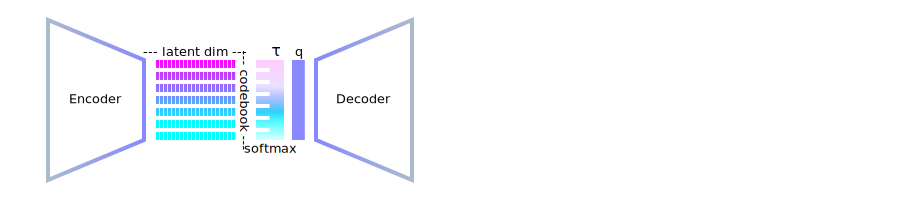

In [27]:
SVG('assets/dvae.svg')

In [28]:
class GEncoder(nn.Module):
    """
    Enhance our existing encoder with a sense of proper data distribution including categorical
    and allow some optional semantic channel interact with it
    """
    def __init__(self, encoder: nn.Module, latent_dim: int, categorical_dim: int, semantic_dim: int = 0):
        super().__init__()
        self.latent_dim = latent_dim
        self.categorical_dim = categorical_dim
        self.semantic_dim = semantic_dim
        self.encoder = encoder
        self.neck = Neck(latent_dim * categorical_dim, semantic_dim)
        
    def encode(self, x, context: Optional[Tensor] = None):
        return self.neck(self.encoder(x), context)

    def gumbel_sample(self, shape, eps=1e-10):
        """
        scale 0 location 1 Gumbel dist: -log(-log(U(0,1))) 
        """
        return -torch.log(-torch.log(torch.rand(shape).to(DEVICE) + eps) + eps)

    def gumbel_softmax(self, x, temperature):
        """
        add Gumbel noise to the logits (x), apply temperature and softmax
        """
        h = x + self.gumbel_sample(x.size())
        h = torch.softmax(h / temperature, dim=-1)
        return h.view(-1, self.latent_dim * self.categorical_dim)
    
    def forward(self, x, context: Optional[Tensor] = None, temperature: Optional[float] = 1.):
        h = self.encode(x, context)
        h = h.view(h.size(0), self.latent_dim, self.categorical_dim)
        # posterior and prior
        q = torch.softmax(h, dim=-1).view(h.size(0), self.latent_dim * self.categorical_dim)
        p = self.gumbel_softmax(h, temperature)
        return p, q
    

p, q = GEncoder(encoder, LATENT_DIM, CATEGORICAL_DIM).to(DEVICE)(X, S, 0.5)
p.shape, q.shape

(torch.Size([16, 80]), torch.Size([16, 80]))

We are going to reuse the [decoder model architecture](#zdecoder):

In [29]:
ZDecoder(decoder, LATENT_DIM * CATEGORICAL_DIM, SEMANTIC_DIM).to(DEVICE)(p, S)[0].shape

torch.Size([16, 1, 22, 22])

In [30]:
class DVAE(nn.Module):
    """
    Take our existing encoder and decoder and build DVAE connector
    with optional noisy semantic channel
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module,
                       latent_dim: int, categorical_dim: int,
                       encoder_semantic_dim: int = 0, decoder_semantic_dim: int = 0,
                       tau: float = 1.):
        super().__init__()
        self.latent_dim = latent_dim
        self.categorical_dim = categorical_dim
        # noise balansing parameter
        self.tau = nn.Parameter(torch.tensor([tau]))
        # adjusted encoder and decoder
        self.encoder = GEncoder(encoder, latent_dim, categorical_dim, encoder_semantic_dim)
        self.decoder = ZDecoder(decoder, latent_dim * categorical_dim, decoder_semantic_dim)
        # output tags
        self.keys = ['rec-DVAE','q','p','tau','p-context']
        
    @staticmethod
    def translate(semantic_dim, context, temperature):
        """
        for different scenarios:
        unsupervised arbitrary floating point semantic vector goes as is
        while labels need encoding, and maybe noise if semantic channel set to be noisy
        """
        if semantic_dim == 0:
            return None
        if context is None or torch.is_floating_point(context):
            return context
        context = F.one_hot(context, num_classes=semantic_dim).to(DEVICE)
        if temperature is None:
            return context
        return RelaxedOneHotCategorical(temperature, probs=context).sample()
            
    def forward(self, x, context: Optional[Tensor] = None, temperature: Optional[float] = None):
        if temperature is None:
            temperature = torch.exp(self.tau)
        # representation: prior and posterior
        p, q = self.encoder(x, self.translate(self.encoder.semantic_dim, context, temperature), temperature)
        # reconstruction and its source conditioned representation
        rec, pcontext = self.decoder(p, self.translate(self.decoder.semantic_dim, context, temperature))
        return rec, p, q, self.tau, pcontext
    
    @torch.no_grad()
    def sample(self, num_samples, context: Optional[Tensor] = None, temperature: Optional[float] = 1.):
        if self.decoder.semantic_dim == 0:
            context = None
        if type(context) == int:
            context = (torch.ones(num_samples) * context).long().to(DEVICE)
        # condition without semantic noise
        context = self.translate(self.decoder.semantic_dim, context, None)
        d = self.latent_dim * self.categorical_dim
        probs = torch.ones((num_samples, self.latent_dim, self.categorical_dim))/self.categorical_dim
        if temperature is None:
            p = OneHotCategorical(probs=probs.to(DEVICE)).sample().view(num_samples, d)
        else:
            p = RelaxedOneHotCategorical(temperature, probs=probs.to(DEVICE)).sample().view(num_samples, d)
        return self.decoder(p, context)[0]

    
model = DVAE(encoder, decoder, LATENT_DIM, CATEGORICAL_DIM, SEMANTIC_DIM, SEMANTIC_DIM).to(DEVICE)
for output in model(X, S, 0.5): print(output.shape)

torch.Size([16, 1, 22, 22])
torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([1])
torch.Size([16, 80])


In [31]:
label = np.random.randint(SEMANTIC_DIM)
model.sample(10, label, 0.5).shape

torch.Size([10, 1, 22, 22])

<a name="beasts"></a>

### Fancy beasts
We've got our basic blocks, now let's construct some structures we want to explore. We have an encoder and decoder pair used in several different tasks trained jointly -- they could either enhance and regularize each other, or they could block each other out. The scenario would depend on the data: checking this dynamics may help with diagnostics some complicated cases.

<a name="twin"></a>
Our first beast is a variational encoder with two heads: one Gaussian and one Gumbel.

In [32]:
class TwinVAE(nn.Module):
    """
    Take an encoder-decoder pair and build conjoined twins VAE + DVAE
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module,
                       latent_dim: int, categorical_dim: int,
                       encoder_semantic_dim: int = 0, decoder_semantic_dim: int = 0,
                       tau: float = 1.):
        super().__init__()
        # system thermometer
        self.tau = nn.Parameter(torch.tensor([tau]))
        # twin-models
        self.vae = VAE(encoder, decoder, latent_dim,
                       encoder_semantic_dim, decoder_semantic_dim, tau)
        self.dvae = DVAE(encoder, decoder, latent_dim, categorical_dim,
                         encoder_semantic_dim, decoder_semantic_dim, tau)
        # all the outputs tagged
        self.keys = ['rec-VAE','z','mean','log-variance','rec-DVAE','p','q','tau','z-context','p-context']
        
    def sample(self, num_samples, context: Optional[Tensor] = None, temperature: Optional[float] = 1.,
               categorical: Optional[bool] = False):
        if categorical:
            return self.dvae.sample(num_samples, context, temperature)
        return self.vae.sample(num_samples, context, temperature)
        
    def forward(self, x, context: Optional[Tensor] = None, temperature: Optional[float] = None):
        if temperature is None:
            temperature = torch.exp(self.tau)
        # vae reconstruction
        c = self.vae.translate(self.vae.encoder.semantic_dim, context, temperature)
        z, mean, logvar = self.vae.encoder(x, c)
        c = self.vae.translate(self.vae.decoder.semantic_dim, context, temperature)
        zrec, zcontext = self.vae.decoder(z, c)
        # dvae reconstruction
        c = self.dvae.translate(self.dvae.encoder.semantic_dim, context, temperature)
        p, q = self.dvae.encoder(x, c, temperature)
        c = self.dvae.translate(self.dvae.decoder.semantic_dim, context, temperature)
        grec, pcontext = self.dvae.decoder(p, c)
        return zrec, z, mean, logvar, grec, p, q, self.tau, zcontext, pcontext


S = torch.rand(X.size(0), SEMANTIC_DIM).to(DEVICE)
model = TwinVAE(encoder, decoder, LATENT_DIM, CATEGORICAL_DIM, SEMANTIC_DIM, SEMANTIC_DIM).to(DEVICE)
for output in model(X, C): print(output.shape)

torch.Size([16, 1, 22, 22])
torch.Size([16, 8])
torch.Size([16, 8])
torch.Size([16, 8])
torch.Size([16, 1, 22, 22])
torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([1])
torch.Size([16, 8])
torch.Size([16, 80])


In [33]:
model.sample(1, label, True).shape

torch.Size([1, 1, 22, 22])

<a name="hydra"></a>
Our second beast is a variational encoder with an additional regular AE head.

In [34]:
class HydraVAE(nn.Module):
    """
    Take an encoder-decoder pair and build conjoined twins VAE/DVAE + AE
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module,
                       latent_dim: int, categorical_dim: int = None,
                       encoder_semantic_dim: int = 0, decoder_semantic_dim: int = 0,
                       tau: float = 1.):
        super().__init__()
        self.tau = nn.Parameter(torch.tensor([tau]))
        self.ae = AutoEncoder(encoder, decoder)
        self.categorical = categorical_dim is not None
        if self.categorical: # gumbel-vae
            self.dvae = DVAE(encoder, decoder, latent_dim, categorical_dim,
                             encoder_semantic_dim, decoder_semantic_dim, tau)
            self.keys = ['rec-AE','rec-DVAE','p','q','tau','p-context']
        else: # vanilla-vae
            self.vae = VAE(encoder, decoder, latent_dim,
                           encoder_semantic_dim, decoder_semantic_dim, tau)
            self.keys = ['rec-AE','rec-VAE','z','mean','log-variance','tau','z-context']
        
    def sample(self, num_samples, context: Optional[Tensor] = None, temperature: Optional[float] = 1.):
        if self.categorical:
            return self.dvae.sample(num_samples, context, temperature)
        return self.vae.sample(num_samples, context, temperature)

    def forward(self, x, context: Optional[Tensor] = None, temperature: Optional[float] = None):
        if temperature is None:
            temperature = torch.exp(self.tau)
        rec = self.ae(x)
        if self.categorical: # gumbel-vae
            c = self.dvae.translate(self.dvae.encoder.semantic_dim, context, temperature)
            p, q = self.dvae.encoder(x, c, temperature)
            c = self.dvae.translate(self.dvae.decoder.semantic_dim, context, temperature)
            grec, pcontext = self.dvae.decoder(p, c)
            return rec, grec, p, q, self.tau, pcontext
        # vanilla vae
        c = self.vae.translate(self.vae.encoder.semantic_dim, context, temperature)
        z, mean, logvar = self.vae.encoder(x, c)
        c = self.vae.translate(self.vae.decoder.semantic_dim, context, temperature)
        zrec, zcontext = self.vae.decoder(z, c)
        return rec, zrec, z, mean, logvar, self.tau, zcontext
    

model = HydraVAE(encoder, decoder, LATENT_DIM, None, SEMANTIC_DIM, SEMANTIC_DIM).to(DEVICE)
for output in model(X, S, 0.5):
    print(output.shape)

torch.Size([16, 1, 22, 22])
torch.Size([16, 1, 22, 22])
torch.Size([16, 8])
torch.Size([16, 8])
torch.Size([16, 8])
torch.Size([1])
torch.Size([16, 8])


In [35]:
model.sample(1, label, 0.5).shape

torch.Size([1, 1, 22, 22])

<a name="loss"></a>

## Loss definition
To use backpropagation we need to define a differentiable loss function.
The main approach is to jointly optimize the reconstruction and the distance between parameterized $q(z|x)$ and $p(z|x)$: first takes care of neural network learning data, second makes sure that we learn a proper distribution along the way.

Training VAE could be confusing: it explicitly claims using tricks, and, it is a hybrid model. The theoretical constructs from probabilistic models could be very useful for some simple examples like MNIST, but could be more of a distraction and hard to follow with complicated data. (One of objectives of machine learning is to minimize necessity of search for closed theoretical solution to deliver a sufficiently useful result.) Let's go simple way.

In [36]:
# get sample outputs to play with
output = TwinVAE(encoder, decoder, LATENT_DIM, CATEGORICAL_DIM, SEMANTIC_DIM, SEMANTIC_DIM).to(DEVICE)(X, C)
zrec, Z, mean, logvar, grec, P, Q, tau, zcontext, pcontext = output

<a name="rec"></a>

### Reconstruction error
The `reconstruction error` measures how close the reconstructed image is to the original. 
This one seems straight forward, we can use `MSE` or `BCE`/`CrossEntropy` whichever fits our data most (number of channels, unbalanced channel representation etc.) do not get distracted by statements like `IMAGENET` suggests Gaussian, binarized `MNIST` suggests Bernoulli.

The confusion with this one comes from which `reduction` to use. Well, theoretically we should `sum` over our minibatch if we get KLD stats from. Practically, it doesn't really matter, as soon as it [scaled up sufficiently](AE-Experiments-Setup.ipynb#test). Let's check the scale of our prospect options with our untrained model.

In [37]:
class ReconstructionLoss(nn.Module):
    """
    value depends on batch size and image-size
    """
    def __init__(self, loss: nn.Module, weight: float = 0., trainable: bool = False):
        super().__init__()
        self.loss = loss
        weight = torch.Tensor([weight]).to(DEVICE)
        self.weight = nn.Parameter(weight) if trainable else weight
        
    def forward(self, x, y):
        return self.loss(x.squeeze(), y.squeeze()) * torch.exp(self.weight)


# losses we consider
options = {'MSE':nn.MSELoss, 'CrossEntropy':nn.CrossEntropyLoss, 'BCE':nn.BCEWithLogitsLoss }
#       image-size,  image-area
norm = [1./REC_SIZE, 1./REC_SIZE ** 2]

# check the value scale at initiation
for key, opt in options.items():
    for reduction in ['sum','mean']:
        loss = ReconstructionLoss(opt(reduction=reduction), 1.)
        print(f'{key}[{reduction}]:\t{loss.to(DEVICE)(zrec.squeeze(), Y.to(DEVICE)).item():,.4f}')
        for k,w in zip(['W','WxH'], norm):
            loss = ReconstructionLoss(opt(reduction=reduction), w)
            print(f'{key}[{reduction}]/{k}:\t{loss.to(DEVICE)(zrec.squeeze(), Y.to(DEVICE)).item():,.4f}')
    print()

MSE[sum]:	143,733,600.0000
MSE[sum]/W:	55,335,580.0000
MSE[sum]/WxH:	52,986,000.0000
MSE[mean]:	18,560.6387
MSE[mean]/W:	7,145.6064
MSE[mean]/WxH:	6,842.2002

CrossEntropy[sum]:	2,292,864.0000
CrossEntropy[sum]/W:	882,723.0625
CrossEntropy[sum]/WxH:	845,242.1250
CrossEntropy[mean]:	6,513.8188
CrossEntropy[mean]/W:	2,507.7363
CrossEntropy[mean]/WxH:	2,401.2563

BCE[sum]:	249,180.0625
BCE[sum]/W:	95,931.1094
BCE[sum]/WxH:	91,857.8203
BCE[mean]:	32.1772
BCE[mean]/W:	12.3878
BCE[mean]/WxH:	11.8618



The bigger loss value generates bigger gradients, in our case it defined by our output image shape and batch size -- that's the numbers we should keep in mind.

<a name="kld"></a>

### KL-diversion: VAE
The Kullback–Leibler divergence measures the distance between the two distributions: in our case the variational posterior $q$ and the prior $p$ on the latent variable. With both the prior and posterior defined to be diagonal Gaussians this term has a closed-form solution:
#### $KLD_{(q \lVert p)} = -\frac{1}{2} \displaystyle\sum_{i=1}^{D} (1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2)$

We are not going to depth Math here, just for the reference:
#### $H(p, q) = - \displaystyle\sum_x p(x)\log(q(x))$
#### $KLD(q \lVert p) = - \displaystyle\sum_x p(x)\log\left(\dfrac{q(x)}{p(x)}\right)$
#### $H(p, q) = H(p) + KLD(q \lVert p)$

In [38]:
class KLDGaussianLoss(nn.Module):
    """
    assuming diagonal Gaussian prior and posterior
    """
    def __init__(self, reduction: str = 'mean', weight: float = 0., trainable: bool = False):
        super().__init__()
        self.reduction = reduction
        weight = torch.Tensor([weight]).to(DEVICE)
        self.weight = nn.Parameter(weight) if trainable else weight
        
    def forward(self, mean, logvar):
        loss = (mean.pow(2) + logvar.exp() - logvar - 1.) * 0.5
        if self.reduction == 'mean':
            return torch.sum(loss, axis=1).mean() * torch.exp(self.weight)
        return torch.sum(loss) * torch.exp(self.weight)
    

# check the scale
for reduction in ['sum','mean']:
    loss = KLDGaussianLoss(reduction)
    print(f'KLDGaussianLoss[{reduction}]:\t{loss.to(DEVICE)(mean, logvar).item():.4f}')

KLDGaussianLoss[sum]:	0.1033
KLDGaussianLoss[mean]:	0.0065


This term cause maybe most of "operational" confusion. It called `regularization`, but what it regularizes is the resulting (learned) distribution, not the training process. From the perspective of the training process it could be (and it is in the MNIST case) an [adversarial term: it may need to grow](AE-Experiments-Setup.ipynb#test) first. Usually, it is not a problem due to the respective scales: in the beginning of the training the reconstruction loss are so heavily dominating that it allows necessary KLD grows sneak behind.

Let's see how this distributed with different batch-sizes and reductions:

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
with torch.no_grad():
    for i, r in enumerate(['mean','sum']):
        test, batch_sizes = [], [8, 16, 32, 64, 128]
        loss = KLDGaussianLoss(r).to(DEVICE)
        for _ in range(500):
            b, d = int(np.random.choice(batch_sizes)), np.random.randint(2, 512)
            model = VAE(encoder, decoder, d, SEMANTIC_DIM).to(DEVICE)
            for x, _, _ in DataLoader(dataset(trainset), batch_size=b, shuffle=True):
                _, _, mu, lv, _, _ = model(x.to(DEVICE))
                test.append((b, d, loss(mu, lv).item()))
                break
        test = np.array(test)
        for j in range(2):
            l, c = ['batch-size','latent-dim'][j], ['batch-size','latent-dim'][1 - j]
            ax[i][j].scatter(test[:,j], test[:,2], c=test[:,1 - j], cmap='coolwarm', s=5, alpha=0.5)
            ax[i][j].set_xlabel(l, fontsize=8)
            ax[i][j].set_title(f'KLDGaussianLoss[ {r} ]   color[ {c} ]', fontsize=10)
            ax[i][j].set_yscale('log')
        ax[i][0].set_xscale('log')
        ax[i][0].set_xticks(batch_sizes)
        ax[i][0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()

<a name="kld-dvae"></a>

### KL-diversion: DVAE
The divergence of the latent probability distribution with the uniform prior $1/C$ for all categories where $C$ is the codebook size (number of categories).

#### $KLD_{(q \lVert p)} = \mathbb{E}_q \bigg[ \log \dfrac{q(x)}{p(x)} \bigg] = \displaystyle\sum_{j=1}^{C} q(x_i) \log (C \cdot q(x_i))$

In [40]:
class KLDGumbelLoss(nn.Module):
    """
    assuming uniform prior 1/#categories for all categories
    """
    def __init__(self, categorical_dim: int, reduction: str = 'mean', weight: float = 0.,
                 trainable: bool = False):
        super().__init__()
        self.dim = categorical_dim
        self.reduction = reduction
        weight = torch.Tensor([weight]).to(DEVICE)
        self.weight = nn.Parameter(weight) if trainable else weight
        
    def forward(self, proba):
        if self.reduction == 'mean':
            return torch.sum(proba * torch.log(proba * self.dim + 1e-11), dim=1).mean() * torch.exp(self.weight)
        return torch.sum(proba * torch.log(proba * self.dim + 1e-11)) * torch.exp(self.weight)


# check the scale
for reduction in ['sum','mean']:
    loss = KLDGumbelLoss(CATEGORICAL_DIM, reduction)
    print(f'KLDGumbelLoss[{reduction}]:\t{loss.to(DEVICE)(Q).item():.4f}')

KLDGumbelLoss[sum]:	0.2419
KLDGumbelLoss[mean]:	0.0151


In [ ]:
# lets check how it comes out with different configuration
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
with torch.no_grad():
    for i, r in enumerate(['mean','sum']):
        test = []
        for _ in range(500):
            b, d, c = int(np.random.choice(batch_sizes)), np.random.randint(2, 512), np.random.randint(2, 20)
            model = DVAE(encoder, decoder, d, c, SEMANTIC_DIM).to(DEVICE)
            loss = KLDGumbelLoss(c, r).to(DEVICE)
            for x, _, _ in DataLoader(dataset(trainset), batch_size=b, shuffle=True):
                _, _, q, _, _ = model(x.to(DEVICE))
                test.append((b, d, c, loss(q).item()))
                break
        test = np.array(test)
        for j, l in enumerate(['batch-size','latent-dim']):
            ax[i][j].scatter(test[:,j], test[:,3], c=test[:,2], cmap='coolwarm', s=5, alpha=0.5)
            ax[i][j].set_xlabel(l, fontsize=8)
            ax[i][j].set_title(f'KLDGumbleLoss[ {r} ]   color[ categoric-dim ]', fontsize=9)
            ax[i][j].set_yscale('log')
        ax[i][0].set_xscale('log')
        ax[i][0].set_xticks(batch_sizes)
        ax[i][0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()

<a name="helpers"></a>

## Helper terms
Finally, we are going to introduce a couple of helper terms to assist with intuition on the training process and diagnostics of the status. These terms are not the loss components neither regularization in general, they are intuitive metrics that expected to go along with our main objectives. However, in some cases they could be either loss components or regularization, or both.

<a name="contrast"></a>

### Contrast
VAE can suffer from posterior collapse, where the encoder gets stuck in a trivial latent space. Sometimes a training failure blamed on a poor starter representation to begin with. Either way, we want the differences between the samples get properly attended.  Similar to contrast learning we specifically want the non-identical samples represented differently. However, we should be careful not to get in the way of generalization.

The term defined with diagonal target in mind, and collinear representations penalized the most in the batch of distinct (not necessarily different class) samples. The metric "sensitivity" depends on the batch size and latent space size, so we scaled it with those parameters.

In [42]:
class ContrastLoss(nn.Module):
    """
    focus on difference: make covariance look more like identity
    """
    def __init__(self, weight: float = 0., trainable: bool = False):
        super().__init__()
        weight = torch.Tensor([weight]).to(DEVICE)
        self.weight = nn.Parameter(weight) if trainable else weight

    def forward(self, x):
        b, d = x.size()
        C = torch.abs(x @ x.T)
        return (1. - torch.trace(C)/torch.sum(C)) * np.log(d + b) * torch.exp(self.weight)

    
for x,v in zip([Z, mean, P, Q],['z','mean','p','q']):
    print(f'VAE ContrastLoss({v}):\t{ContrastLoss().to(DEVICE)(x).item():.4f}')

VAE ContrastLoss(z):	2.5804
VAE ContrastLoss(mean):	2.9428
VAE ContrastLoss(p):	4.1926
VAE ContrastLoss(q):	4.2789


In [ ]:
# lets check how it comes out with different configuration
with torch.no_grad():
    test = []
    loss = ContrastLoss().to(DEVICE)
    for _ in range(500):
        b, d = int(np.random.choice(batch_sizes)), np.random.randint(2, 512)
        model = VAE(encoder, decoder, d, SEMANTIC_DIM).to(DEVICE)
        for x, _, _ in DataLoader(dataset(trainset), batch_size=b, shuffle=True):
            _, z, mu, _, _, _ = model(x.to(DEVICE))
            test.append((b, d, loss(z).item()))
            break
test = np.array(test)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for j in range(2):
    l, c = ['batch-size','latent-dim'][j], ['batch-size','latent-dim'][1 - j]
    ax[j].scatter(test[:,j], test[:,2], c=test[:,1 - j], cmap='coolwarm', s=5, alpha=0.5)
    ax[j].set_xlabel(l, fontsize=8)
    ax[j].set_title(f'ContrastLoss[ {r} ]   color[ {c} ]', fontsize=10)
ax[0].set_xscale('log')
ax[0].set_xticks(batch_sizes)
ax[0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()

In [ ]:
loss = ContrastLoss().to(DEVICE)
b = 16
for d in [b * n for n in [1, 4, 16, 32]]:
    N = [np.random.normal(size=(b, d)),
         np.tile(np.random.normal(size=(d,)), (b, 1)) * np.random.rand(b, 1),
         np.concatenate((np.eye(b) * np.random.normal(1., 1., size=(b, 1)), np.zeros((b, d - b))), axis=1)]
    M = [np.abs(x.dot(x.T)) for x in N]
    fig, ax = plt.subplots(1, 6, figsize=(9, 9))
    for i, (x, m) in enumerate(zip(N, M)):
        ax[i * 2].imshow(x, cmap='coolwarm')
        ax[i * 2].set_title(['random','collinear','ortogonal'][i], fontsize=10)
        ax[i * 2].set_xticks([])
        ax[i * 2].set_yticks([])
        ax[i * 2 + 1].imshow(m, cmap='coolwarm')
        ax[i * 2 + 1].set_title(f'loss: {loss(torch.Tensor(x).to(DEVICE)).cpu().item():.4f}', fontsize=10)
        ax[i * 2 + 1].set_xticks([])
        ax[i * 2 + 1].set_yticks([])
    ax[0].set_xlabel(f'--- latent-dim {d} ---', fontsize=8)
    ax[0].set_ylabel(f'--- batch {b} ---', fontsize=6)        
    plt.tight_layout()
    plt.show()

<a name="align"></a>

### Semantic align
This one is basically a simple `cosine similarity`. With training progress when we merge `context` we expect the `context-projection` to be progressively more aligned with the incoming representation if there's no conflict. We can use cosine-similarity as a measure of this alignment.

In [45]:
class AlignLoss(nn.Module):
    """
    cosine similarity between `perceived` and `hinted`
    """
    def __init__(self, weight: float = 0., trainable: bool = False):
        super().__init__()
        weight = torch.Tensor([weight]).to(DEVICE)
        self.weight = nn.Parameter(weight) if trainable else weight

    def forward(self, x, y):
        xnorm, ynorm = torch.sum(x ** 2, dim=1), torch.sum(y ** 2, dim=1)
        if torch.any(xnorm) and torch.any(ynorm):
            norm = (xnorm * ynorm) ** 0.5
            return 1. - torch.mean(torch.sum(x * y, dim=1)/norm) * torch.exp(self.weight)
        return torch.Tensor([1.])


align = AlignLoss().to(DEVICE)
print(f'VAE AlignLoss(z, context):\t{align(Z, zcontext).item():.4f}\t\tAlignLoss(z, z): {align(Z, Z).item():.4f}')

VAE AlignLoss(z, context):	1.0389		AlignLoss(z, z): 0.0000


For DVAE case we only align a codebook representation in contrast with the `contrast` metric where we use full resolution (both axes latent and categorical) to calculate the metric.

In [46]:
# align a codebook representation (mean-pool from latent axis)
p = torch.mean(P.view(-1, LATENT_DIM, CATEGORICAL_DIM), dim=-1)
pcontext = torch.mean(pcontext.view(-1, LATENT_DIM, CATEGORICAL_DIM), dim=-1)
print(f'DVAE AlignLoss(p, context):\t{align(p, pcontext).item():.4f}\t\tAlignLoss(p, p): {align(p, p).item():.4f}')

DVAE AlignLoss(p, context):	0.9450		AlignLoss(p, p): 0.0000


<a name="tau"></a>

### Temperature
The last on is a system thermometer, comes handy if we want to penalize the level of the noise. In DVAE we use temperature to control the `gumbel-relaxation`. In the case of a semantic channel presence we use temperature to control the noise in the channel: similar way to make the space more smooth (differentiable).

Here we use `tau` which is log(temperature) for the `trainable` case convenience.

In [47]:
class TauLoss(nn.Module):
    """
    thermometer: measures level of the noise in the system
    """
    def __init__(self, weight: float = 0., trainable: bool = False):
        super().__init__()
        weight = torch.Tensor([weight]).to(DEVICE)
        self.weight = nn.Parameter(weight) if trainable else weight

    def forward(self, x, y=0):
        #sreturn x ** 2 ### distance from the regular softmax
        #return 0. ### do not penalize temperature        
        return (torch.exp(x) - y) ** 4 * torch.exp(self.weight) ### distance from a specific freezing point
    